# Credit Card Fraud Detection: Handling Imbalanced Data for Classification (Part 1)

Author: **Marcin Sikorski**<br>
Date: November, 2024

A common issue in machine learning classification tasks is handling unbalanced data, which is characterized by a skewed class distribution with a considerable over-representation of one class over the others. This component makes models exhibit inferior performance due to bias toward the majority class. This problem can be minimized by applying specialized strategies like resampling, ensemble approaches, utilizing appropriate metrics (F1 score, precision, recall, ROC), and putting advanced algorithms to work with imbalanced datasets into practice.

An imbalanced dataset occurs when the distribution of observations in the target class is uneven - one class label has a significantly higher number of observations, while the other has a notably lower count. That is a case when resampling strategies can be a remedy. Furthermore, it is possible to evaluate a model's performance more precisely by substituting other assessment measures.

This notebook demonstrates a credit card fraud detection. Credit card companies must detect fraudulent transactions to prevent consumers from being charged for products they did not buy. This challenge can be coupled with machine learning. The main issue of this classification task is to overcome heavy data imbalance.

**Notebook Content:**
1. Importing & Data Preparation<br>
    1.1. Data Description<br>
    1.2. Data Skewness
2. Data Scaling & Splitting
3. No Sampling
4. K-Means Oversampling
5. ADASYN Oversampling
6. SMOTE & ENN
7. Random Undersampling
8. Near Miss Undersampling
9. Random Oversampling
10. Balance Bagging Classifying
11. Conclusions

### 1. Importing & Data Preparation

We will start from loading the dataset and performing EDA (exploratory data analysis) to achieve information and basic insights of the features and their distributions. The dataset origins from [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud).

In [1]:
import pandas as pd
import numpy as np
from prettytable import PrettyTable
import matplotlib.pyplot as plt

# read file & drop duplicates
df = pd.read_csv('archive.zip', compression='zip', header=0, sep=',')
df.drop_duplicates(inplace=True)

# show rows & columns in ASCII table
table = PrettyTable(['Instances', 'Features'], align='l', header_style=None)
table.add_row([len(df), df.shape[1]])
print(table)

df.head()

+-----------+----------+
| Instances | Features |
+-----------+----------+
| 283726    | 31       |
+-----------+----------+


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**1.1. Data Description**

The dataset contains transactions made by credit cards in September 2013 by European cardholders that occurred over two days - positive (non-fraud) and negative (fraud). The dataset is highly imbalanced. Below is the content of the dataset:

* `Time` contains the seconds elapsed between each transaction and the first transaction in the dataset.
* Features `V1`, `V2`, ..., `V28` are numerical input variables; they are principal components obtained in PCA transformation. Due to confidentiality issues, the original features are not provided and no further information is given.
* `Amount` is the transaction amount, this feature can be used for example-dependent cost-senstive learning.
* `Class` is the response variable and binary target. It describes whether the transaction was fraud or not.

Only `Time` and `Amount` are not transformed.

In [2]:
# display data type & count null values 
col_list = df.columns.to_list()
dtype_list = []
null_list = []

for col in df.columns:
    dtype_list.append(df[col].dtype)
    null_list.append(df[col].isnull().sum())
table = PrettyTable(['Feature', 'Data type', 'Null values'], align='l')

for i, j, k in zip(col_list, dtype_list, null_list):
    table.add_row([i, j, k])
print(table)

+---------+-----------+-------------+
| Feature | Data type | Null values |
+---------+-----------+-------------+
| Time    | float64   | 0           |
| V1      | float64   | 0           |
| V2      | float64   | 0           |
| V3      | float64   | 0           |
| V4      | float64   | 0           |
| V5      | float64   | 0           |
| V6      | float64   | 0           |
| V7      | float64   | 0           |
| V8      | float64   | 0           |
| V9      | float64   | 0           |
| V10     | float64   | 0           |
| V11     | float64   | 0           |
| V12     | float64   | 0           |
| V13     | float64   | 0           |
| V14     | float64   | 0           |
| V15     | float64   | 0           |
| V16     | float64   | 0           |
| V17     | float64   | 0           |
| V18     | float64   | 0           |
| V19     | float64   | 0           |
| V20     | float64   | 0           |
| V21     | float64   | 0           |
| V22     | float64   | 0           |
| V23     | 

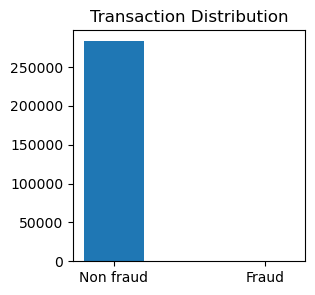

+-----------+--------+---------+
| Class     | Count  | Percent |
+-----------+--------+---------+
| Non-fraud | 283253 | 99.8333 |
| Fraud     | 473    | 0.1667  |
+-----------+--------+---------+


In [3]:
def count_target(frame):
    '''
    Plots target distribution and displays table with counts & percents.
    '''
    values = frame['Class'].value_counts().tolist()
    
    plt.figure(figsize=(3, 3))
    plt.bar(x=['Non fraud', 'Fraud'], height=values, width=0.4)
    plt.title('Transaction Distribution')
    plt.show()

    percent_non_fraud = round((values[0]*100)/len(frame), 4)
    percent_fraud = round((values[1]*100)/len(frame), 4)
    
    table = PrettyTable(['Class', 'Count', 'Percent'], align='l', header_style=None)
    table.add_row(['Non-fraud', values[0], percent_non_fraud])
    table.add_row(['Fraud', values[1], percent_fraud])
    print(table)
    
count_target(frame=df)

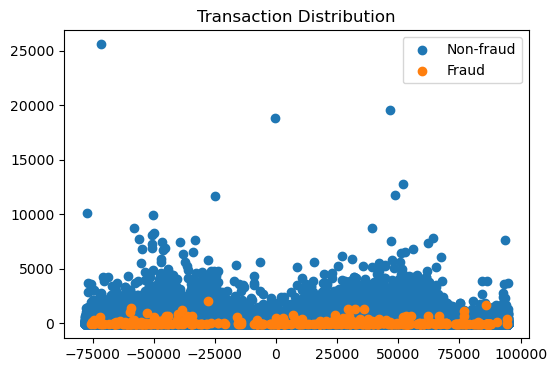

In [4]:
from sklearn.decomposition import PCA

# display class imbalance with scatter plot
# perform PCA sampling for visualization purposes only
pca = PCA(n_components=2)
pca_array = pca.fit_transform(df.iloc[:, 0:30])

# join arrays sideways
array_2d = np.concatenate((pca_array, df['Class'].values.reshape(-1, 1)), axis=1)

# extract columns
col_1 = array_2d[:, 0]
col_2 = array_2d[:, 1]
col_target = array_2d[:, -1]

plt.figure(figsize=(6, 4))
plt.scatter(x=col_1[col_target == 0], y=col_2[col_target == 0], label='Non-fraud')
plt.scatter(x=col_1[col_target == 1], y=col_2[col_target == 1], label='Fraud')
plt.title('Transaction Distribution')
plt.legend()
plt.show()

> The target distribution is heavily imbalanced and skewed. We will need to provide preprocessing steps to fix this issue. The future models will assume most transactions to be not fraud and will not be able to detect patterns for fraud. An imbalanced dataset will not allow the model to capture true correlations between the features and target. Some issues caused by imbalanced datasets include:
> * biased model training (overfitting);
> * poor generalization;
> * inaccurate predictions.

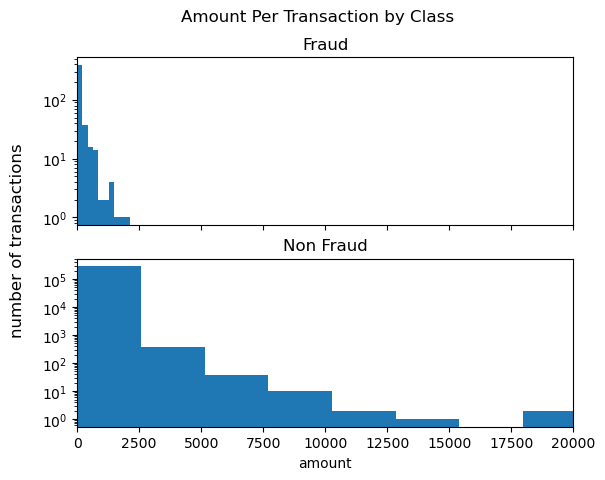

In [5]:
# plot amount per transaction
non_fraud = df[df['Class'] == 0]
fraud = df[df['Class'] == 1]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
fig.suptitle('Amount Per Transaction by Class')
fig.supylabel('number of transactions')

ax1.hist(fraud['Amount'])
ax1.set(title='Fraud', yscale='log')

ax2.hist(non_fraud['Amount'])
ax2.set(title='Non Fraud', xlabel='amount', yscale='log', xlim=(0, 20_000))
plt.show()

> Fraud transactions tend to have much smaller amounts of money.

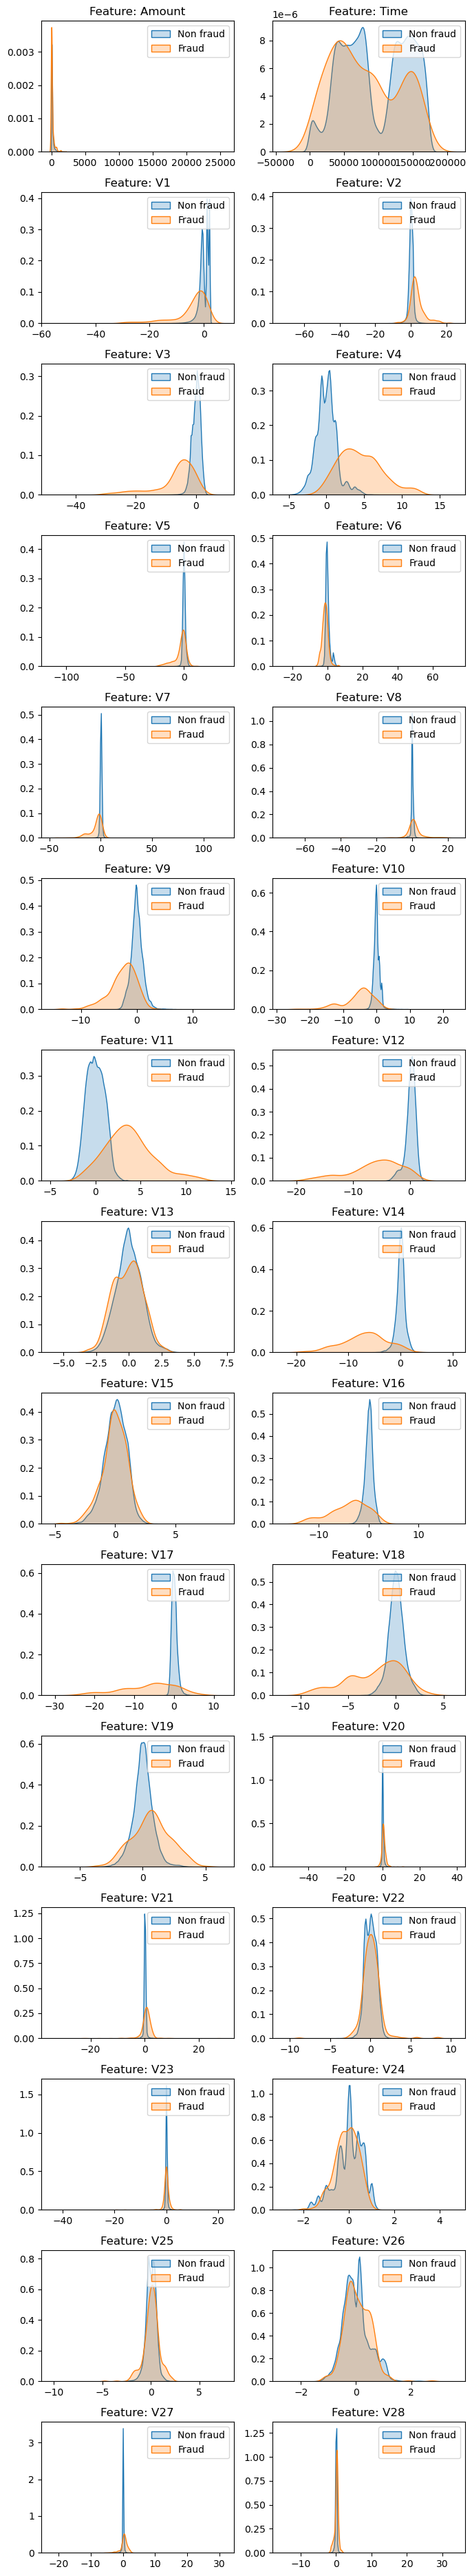

In [6]:
from matplotlib import gridspec
from seaborn import distplot

# reorder columns: Amount, Time
df_plot = df.copy()
amount = df_plot['Amount']
df_plot.drop(labels=['Amount'], axis=1, inplace=True)
df_plot.insert(0, 'Amount', amount)

# plot the distributions of the features
columns = df_plot.iloc[:, 0:30].columns

plt.figure(figsize=(7, 15*2.5))
grids = gridspec.GridSpec(15, 2)

for grid, idx in enumerate(df_plot[columns]):
    ax = plt.subplot(grids[grid])
    distplot(df_plot[idx][df_plot.Class == 0], hist=False, kde_kws={'shade': True}, bins=50, label='Non fraud')
    distplot(df_plot[idx][df_plot.Class == 1], hist=False, kde_kws={'shade': True}, bins=50, label='Fraud')
    ax.set(title=f'Feature: {str(idx)}', xlabel='', ylabel='')
    ax.legend(loc='best')
plt.tight_layout()
plt.show()

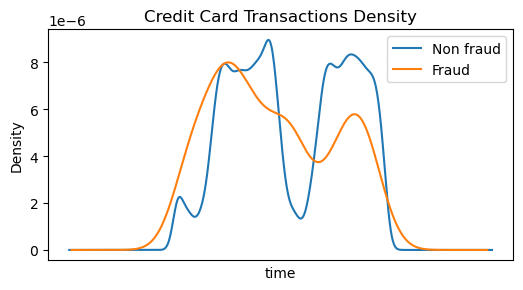

In [7]:
# density plot - target distribution in time
non_fraud = df.loc[df['Class'] == 0]['Time']
fraud = df.loc[df['Class'] == 1]['Time']

plt.figure(figsize=(6, 3))
non_fraud.plot.density(label='Non fraud')
fraud.plot.density(label='Fraud')
plt.title('Credit Card Transactions Density')
plt.xlabel('time')
plt.xticks([])
plt.legend()
plt.show()

> Transactions occur in a cyclical pattern. Fraudulent transactions are more evenly distributed over time compared to valid transactions.

**1.2. Data Skewness**

Skewness is a statistical measure of asymmetric distribution of data compared to a normal distribution. At this step we will investigate the skewness for dataset variables. Adjusting skewness effects the models to be more robust.

In [8]:
# select features for skewness checking
cols = df.drop(['Class', 'Time'], axis=1).columns
cols

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

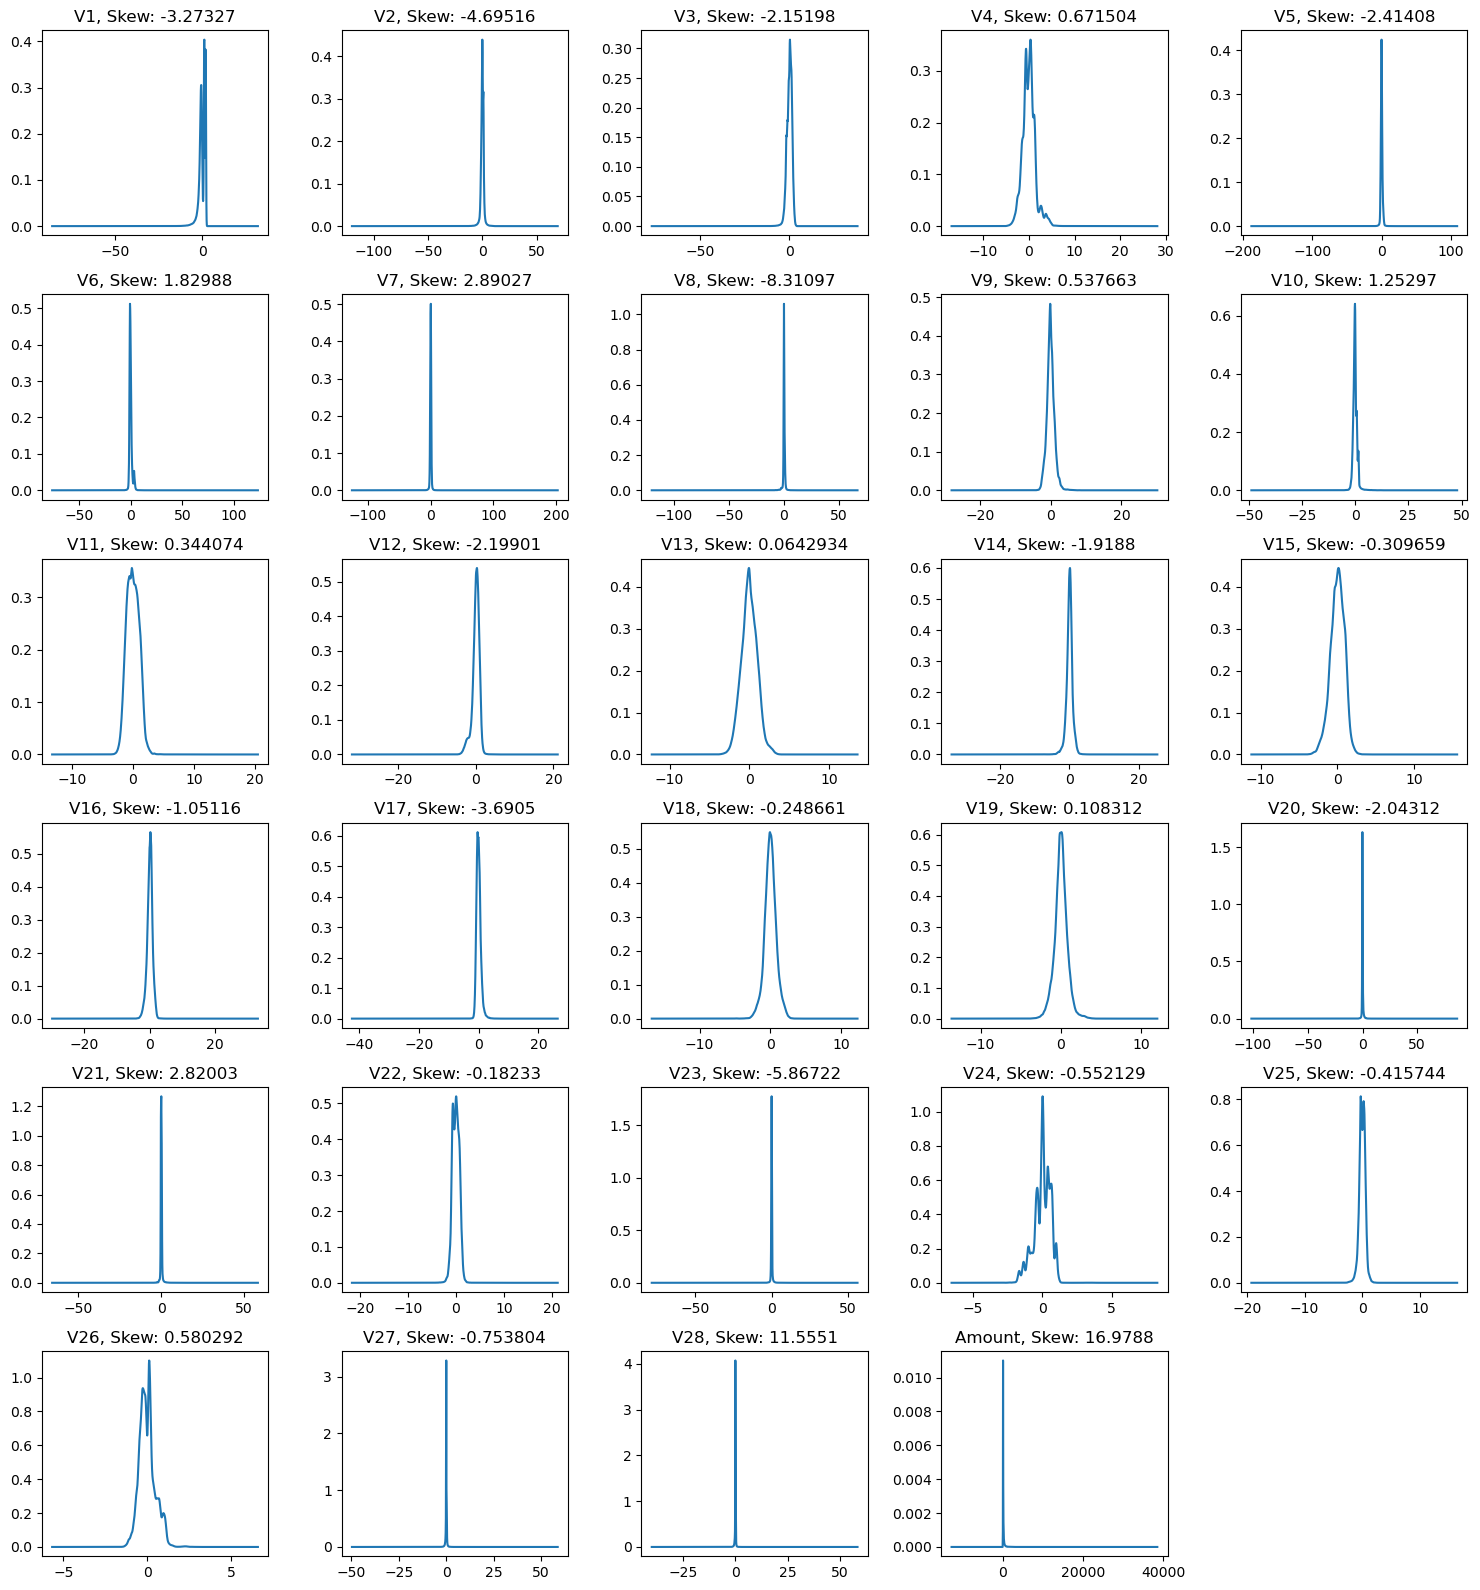

In [9]:
plt.figure(figsize=(15, 16))

# plot the distribution of the variables (skewness)
for i, col in enumerate(cols):
    plt.subplot(6, 5, i+1)

    df[col].plot.density()
    #plt.title(col + ', Skew: ' + str(round(df[col].skew(), 6)))
    plt.title(f'{col}, Skew: {df[col].skew():.6}')
    plt.ylabel(None)

plt.tight_layout()
plt.show()

> Many variables are heavily skewed and have heavy tails. We can address this issue to make them more normally distributed and reduce the skewness. For example, we can apply a power transformation to selected features.

In [10]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson transformation for negative & positive values
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)

df[cols] = pt.fit_transform(df[cols])

# skewness & variance lists
skew_list = round(df[cols].skew(), 6).tolist()
var_list = round(df[cols].var(), 6).tolist()

# print skews & variances after transformation
table = PrettyTable(align='l', header_style=None)
table.add_column('Feature', df[cols].columns.tolist(), align='l')
table.add_column('Skewness', skew_list, align='c')
table.add_column('Variance', var_list, align='l')
print(table)

+---------+-----------+----------+
| Feature |  Skewness | Variance |
+---------+-----------+----------+
| V1      | -0.218575 | 1.000004 |
| V2      |  0.335603 | 1.000004 |
| V3      | -0.078673 | 1.000004 |
| V4      |  0.018864 | 1.000004 |
| V5      |  -1.22015 | 1.000004 |
| V6      | -1.942118 | 1.000004 |
| V7      |  2.434526 | 1.000004 |
| V8      |  2.360907 | 1.000004 |
| V9      |  -0.0435  | 1.000004 |
| V10     |  -1.24498 | 1.000004 |
| V11     |  0.059474 | 1.000004 |
| V12     |  0.156863 | 1.000004 |
| V13     |  0.006184 | 1.000004 |
| V14     |  0.10031  | 1.000004 |
| V15     |  0.013195 | 1.000004 |
| V16     |  0.135621 | 1.000004 |
| V17     |  -0.82707 | 1.000004 |
| V18     | -0.058512 | 1.000004 |
| V19     |  0.015099 | 1.000004 |
| V20     | -0.933071 | 1.000004 |
| V21     | -1.955268 | 1.000004 |
| V22     | -0.020014 | 1.000004 |
| V23     | -0.270709 | 1.000004 |
| V24     |  0.112562 | 1.000004 |
| V25     |  0.077728 | 1.000004 |
| V26     | -0.02423

> Features are now much more symmetric and closer to zero after the power transformation. Variances equal one indicate the features to be standardized or transformed.

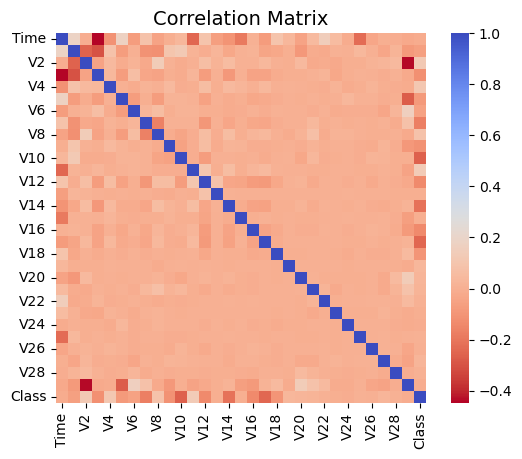

In [11]:
from seaborn import heatmap

# visualize correlations within dataset
heatmap(df.corr(), cmap='coolwarm_r', square=True)
plt.title('Correlation Matrix', fontsize=14)
plt.show()

> The heatmap displays a very low number of correlations with the features. Correlation among features can play a significant role in model performance, especially for linear models.

### 2. Data Scaling & Splitting

We will rescale the `Time` and `Amount` columns with the robust scaler, which should be more prone to outliers. This scaler removes the median and scales the data according to the quantile range (defaults to IQR). The IQR is the range between the 1st quartile (25th quantile) and the 3rd quartile (75th quantile). Since the remaining variables are principal components, feature selection is unnecessary as many features are tiny and will be left untouched.

The variable `Time` contains the seconds elapsed between each transaction and the first transaction in the dataset. The variable `Amount` is the transaction amount.

In [12]:
from sklearn.preprocessing import RobustScaler

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# drop original columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,scaled_amount,scaled_time
0,-0.908517,-0.131109,2.174201,0.986309,-0.257317,0.460075,0.195593,0.022528,0.382316,0.132305,...,0.368766,-0.190040,0.014889,0.212398,-0.323989,0.326111,-0.055175,0,0.727319,-0.995290
1,0.625754,0.094915,-0.033947,0.389851,0.031415,0.046651,-0.063677,0.008792,-0.183999,-0.113185,...,-0.885006,0.153295,-0.637695,0.288921,0.353565,-0.038270,0.056557,0,-0.769227,-0.995290
2,-0.907941,-0.873965,1.381479,0.343686,-0.376027,1.321920,0.643991,0.176162,-1.455515,0.240811,...,1.070494,1.502750,-1.133754,-0.653256,-0.209921,-0.155875,-0.176605,0,1.063378,-0.995279
3,-0.745930,-0.202749,1.401190,-0.579730,-0.019788,0.984293,0.193974,0.314385,-1.321162,-0.005432,...,-0.011101,-0.318214,-1.757165,1.276986,-0.400100,0.144505,0.201741,0,0.656353,-0.995279
4,-0.827019,0.535699,1.161194,0.359431,-0.306955,0.188177,0.482810,-0.333172,0.772533,0.729511,...,1.108704,-0.233430,0.145653,-0.428861,1.053957,0.547559,0.673579,0,0.443484,-0.995267


&#x26A0; Splitting data into test and train sets should always be performed **before** applying sampling techniques! We will split data into train and test set in 80% and 20% respectively, using stratified shuffle split. When performing cross-fold validation, the training set splits into multiple validation subsets. We will perform a test to ensure each of the validation subset contains an equal proportion of the labels of our original training set.

In [13]:
from sklearn.model_selection import StratifiedShuffleSplit

# features X and labels y
X = df.drop('Class', axis=1)
y = df['Class']

# split data before oversampling!
sss = StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2)

for i, (train_idx, test_idx) in enumerate(sss.split(X, y)):
    print(f'Fold {i+1}:')
    print(f'\tTrain: {train_idx}')
    print(f'\tTest:  {test_idx}')
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# check label distribution in both train and test sets - should be similar
train_unique_lab, train_counts_lab = np.unique(y_train, return_counts=True)
test_unique_lab, test_counts_lab = np.unique(y_test, return_counts=True)

percent_train = round((len(y_train) * 100) / len(X), 4)
percent_test = round((len(y_test) * 100) / len(X), 4)

print('\n')
table = PrettyTable(['Subset', 'Distribution', 'Percent'], align='l', header_style=None)
table.add_row(['Train', train_counts_lab/len(y_train), percent_train])
table.add_row(['Test', test_counts_lab/len(y_test), percent_test])
print(table)

Fold 1:
	Train: [225399 133746 185792 ... 241772  60347  66795]
	Test:  [ 86249 250634  20163 ... 115100 186966   8228]
Fold 2:
	Train: [198576 119375  31054 ...      5 265403  53673]
	Test:  [ 13489 203234  68989 ... 280403 134208 224305]
Fold 3:
	Train: [127226 189028 176704 ... 241840 122469 137312]
	Test:  [124615 237217  39824 ... 196634  32580 235597]
Fold 4:
	Train: [229705 214874  59279 ... 200666  81675   8171]
	Test:  [235940 260800 213346 ...  15018  48654 269447]
Fold 5:
	Train: [ 21983  16988  18664 ... 154953 171683 208410]
	Test:  [147277 227806 180974 ... 116172 204028  69600]


+--------+-------------------------+---------+
| Subset | Distribution            | Percent |
+--------+-------------------------+---------+
| Train  | [0.99833466 0.00166534] | 79.9997 |
| Test   | [0.99832587 0.00167413] | 20.0003 |
+--------+-------------------------+---------+


> Each stratified fold seems to have the same distribution. The percentage of each subset is correct.

We will choose and run four popular machine learning classifiers.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

classifiers = {
    'Logisitic Regression': LogisticRegression(),
    'Naïve Bayes': GaussianNB(),
    'K-Neighbors': KNeighborsClassifier(),
    'LightGBM': LGBMClassifier(verbose=-1),
}

&#x26A0; Note that accuracy score is a misleading evaluation metric in such case (normal transactions will be correctly classified and outnumbered, while fraud will not be). Traditional classifiers tend to favor the majority class, neglecting the minority class due to its lower representation. Instead, it will be better to use F1 score, Matthew's correlation coefficient (MCC), confusion matrix, or precision/recall scores.

### 3. No Sampling

We will run the classifiers on the splitted datasets without resampling. The F1 score will be accepted as the main evaluation metric. As previously mentioned, accuracy might mask poor performance on the minority class.

In [15]:
from sklearn.model_selection import cross_val_score

# dictionary to store F1 scores
reg_scores = {}

# initialize score table
table = PrettyTable(['Classifier', 'F1-Score', 'Accuracy'], align='l', header_style=None)

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    f1_score = cross_val_score(classifier, X_train, y_train, cv=5, scoring='f1')
    reg_scores[key] = f1_score.mean()
    accuracy = cross_val_score(classifier, X_train, y_train, cv=5, scoring='accuracy')
    table.add_row([classifier.__class__.__name__, round(f1_score.mean() * 100, 4), round(accuracy.mean() * 100, 4)])

table.reversesort = True
print(table.get_string(sortby='F1-Score'))

+----------------------+----------+----------+
| Classifier           | F1-Score | Accuracy |
+----------------------+----------+----------+
| KNeighborsClassifier | 81.5239  | 99.9449  |
| LogisticRegression   | 73.4379  | 99.9242  |
| LGBMClassifier       | 29.9771  | 99.4911  |
| GaussianNB           | 10.6816  | 97.7381  |
+----------------------+----------+----------+


> The F1 scores do not indicate significant performance. We can easily notice how misleading is the accuracy metric - especially for the Naïve Bayes classifier. This algorithm relies on the prior probability of each class when calculating the likelihood. The majority class will have a very high prior probability and the minority class very low. Accuracy would be an acceptable choice to use after resampling imbalanced data.

The predictions for each classifier will be estimated with cross-validation. The returned outputs will be the binary targets, not probabilities.

In [16]:
from sklearn.model_selection import cross_val_predict

def perform_predictions(X_train, y_train, method='predict'):
    '''
    Returns predictions for each classifier.
    Method: `predict` - returns classes, `predict_proba` - returns probabilities.
    '''
    # define properties
    props_kwargs = {
        'X': X_train,
        'y': y_train,
        'cv': 5,
        'verbose': 0,
        'method': method,
    }

    # store probabilities for each model
    predictions_dict = {}

    # perform cross-validation and store predictions
    for key, classifier in classifiers.items():
        predictions_dict[key] = cross_val_predict(classifier, **props_kwargs)

    return predictions_dict

# no samples predictions
pred_reg = perform_predictions(X_train, y_train)

# display any sample to check results
pred_reg['Logisitic Regression'][12:34]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

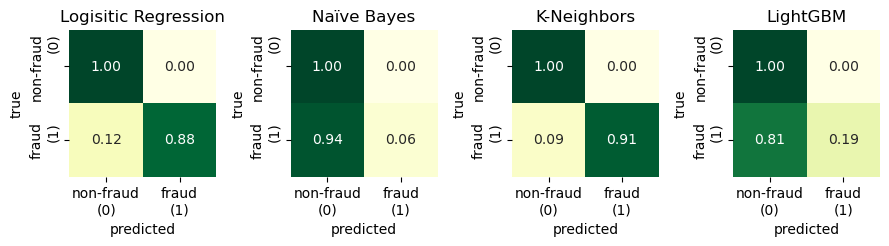

In [17]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(test_set, predictions):
    '''
    Plots normalized confusion matrices for each classifier.
    '''
    # heatmap properties
    heatmap_kwargs = {
        'xticklabels': ['non-fraud\n(0)', 'fraud\n(1)'],
        'yticklabels': ['non-fraud\n(0)', 'fraud\n(1)'],
        'cbar': False,
        'cmap': 'YlGn',
        'fmt': '.2f',
    }

    fig, axes = plt.subplots(1, 4, figsize=(9, 3))
    
    for (key, pred), ax in zip(predictions.items(), axes.flatten()):
        cm = confusion_matrix(pred, test_set, normalize='true')
        heatmap(cm, annot=True, square=True, ax=ax, **heatmap_kwargs)
        ax.set_title(key)
        ax.set_xlabel('predicted')
        ax.set_ylabel('true')
    
    plt.tight_layout()
    plt.show()

plot_confusion_matrices(y_train, pred_reg)

> Confusion matrices visualize the classifying performance in a much more interpretable meaning rather then raw metrics. The k-nearest neighbors algorithm classifies pretty correctly. The logistic regression is also acceptable. The remaining models are biased toward the majority class and class imbalance highly affect them. It is still highly recommended to resample the class distribution.

Approaches to handle imbalanced classes:
* oversampling - generating more instances of the minority class by duplicating existing instances or generating synthetic samples (examples: random oversampling, k-means, SMOTE, ADASYN);
* undersampling - reducing the number of instances in the majority class to balance the class distribution (examples: random undersampling, Tomek links);
* ensemble methods (examples: balanced bagging, boosting);
* hybrid - combining data-level and algorithm-level methods for better results.

In general, almost all of these techniques come down to creating (generating) new balanced datasets with different strategies.

### 4. K-Means Oversampling

To balance the dataset, we can apply k-means clustering. TThis unsupervised technique, along with SMOTE (Synthetic Minority Oversampling TEchnique) technique generates minority class samples in important and representative areas of the input space. SMOTE synthesizes new examples for the minority class. The simple approach involves duplicating examples in the minority class, although these examples don't add any new information to the model.

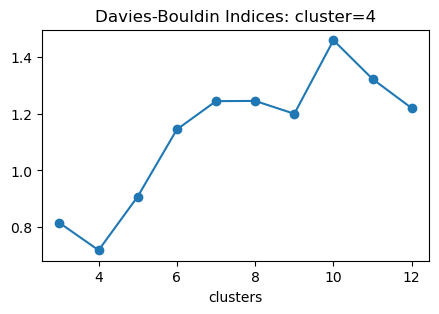

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# separate the majority and minority classes
# majority - 0 (non-fraud)
# minority - 1 (fraud)
majority_class = train_df[train_df['Class'] == 0]
minority_class = train_df[train_df['Class'] == 1]

# list for scores
dav_bould_idx = []

# loop through each k-value
for k in range(3, 13):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(minority_class.drop('Class', axis=1))
    
    dav_bould_idx.append(davies_bouldin_score(minority_class.drop('Class', axis=1), kmeans.labels_))

plt.figure(figsize=(5, 3))
plt.plot(range(3, 13), dav_bould_idx, marker='o')
plt.title(f'Davies-Bouldin Indices: cluster={dav_bould_idx.index(min(dav_bould_idx)) + 3}')
plt.xlabel('clusters')
plt.show()

> Four clusters is the optimum choice for this dataset.

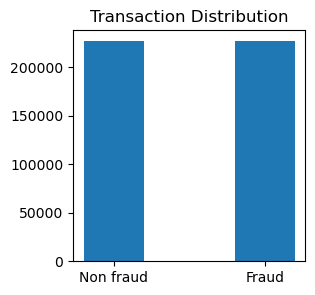

+-----------+--------+---------+
| Class     | Count  | Percent |
+-----------+--------+---------+
| Non-fraud | 226602 | 50.0002 |
| Fraud     | 226600 | 49.9998 |
+-----------+--------+---------+


In [19]:
# apply k-means to the minority class
# number of clusters for the minority class
num_clusters = 4
k_means = KMeans(n_clusters=num_clusters, random_state=42)
k_means.fit(minority_class.drop('Class', axis=1))

# create synthetic samples for each centroid
synthetic_samples = []
num_samples_per_cluster = len(majority_class) // num_clusters

# get cluster centers
centroids = k_means.cluster_centers_

# generate synthetic samples around the centroid
# randomly sample around the centroid using a normal distribution
for centroid in centroids:
    for _ in range(num_samples_per_cluster):
        synthetic_sample = centroid + np.random.normal(loc=0, scale=0.5, size=centroid.shape)
        synthetic_samples.append(synthetic_sample)

# extract header in list
cols = df.drop('Class', axis=1).columns

# dataframe from synthetic samples
synthetic_df = pd.DataFrame(synthetic_samples, columns=cols)
# 1 - minority class
synthetic_df['Class'] = 1

# join training dataset with synthetic samples
kmeans_df = pd.concat([majority_class, synthetic_df], ignore_index=True)

# plot target distribution
count_target(frame=kmeans_df)

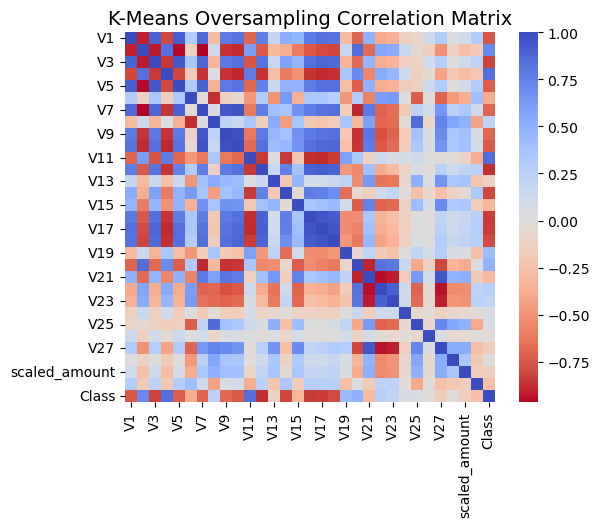

In [20]:
# visualize correlations within dataset
heatmap(kmeans_df.corr(), cmap='coolwarm_r', square=True)
plt.title('K-Means Oversampling Correlation Matrix', fontsize=14)
plt.show()

> We can notice visually how this technique benefits the dataset. There are much more correlations and the new dataset is more much balanced.

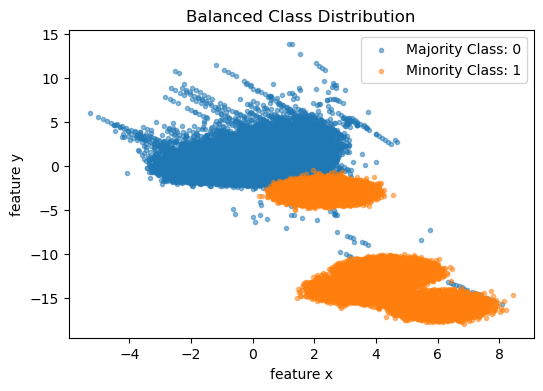


Dataset shapes:
X_train: (453202, 30)
X_test: (56746, 30)
y_train: (453202,)
y_test: (56746,)


In [21]:
zero_v11 = kmeans_df[kmeans_df['Class'] == 0]['V11']
zero_v17 = kmeans_df[kmeans_df['Class'] == 0]['V17']
one_v11 = kmeans_df[kmeans_df['Class'] == 1]['V11']
one_v17 = kmeans_df[kmeans_df['Class'] == 1]['V17']

# visualize the balanced class distribution
plt.figure(figsize=(6, 4))
plt.scatter(x=zero_v11, y=zero_v17, label='Majority Class: 0', alpha=0.5, marker='.')
plt.scatter(x=one_v11, y=one_v17, label='Minority Class: 1', alpha=0.5, marker='.')
plt.title('Balanced Class Distribution')
plt.xlabel('feature x')
plt.ylabel('feature y')
plt.legend()
plt.show()

# split balanced training & test data into features & labels
X_train_kmeans = kmeans_df.drop('Class', axis=1)
y_train_kmeans = kmeans_df['Class']

X_test_kmeans = test_df.drop('Class', axis=1)
y_test_kmeans = test_df['Class']

print('\nDataset shapes:')
print('X_train:', X_train_kmeans.shape)
print('X_test:', X_test_kmeans.shape)
print('y_train:', y_train_kmeans.shape)
print('y_test:', y_test_kmeans.shape)

In [22]:
# dictionary to store F1 scores
kmeans_scores = {}

# initialize score table
table = PrettyTable(['Classifier', 'F1-Score'], align='l', header_style=None)

for key, classifier in classifiers.items():
    classifier.fit(X_train_kmeans, y_train_kmeans)
    training_score = cross_val_score(classifier, X_train_kmeans, y_train_kmeans, cv=5, scoring='f1')
    kmeans_scores[key] = training_score.mean()
    table.add_row([classifier.__class__.__name__, round(training_score.mean() * 100, 4)])

table.reversesort = True
print(table.get_string(sortby='F1-Score'))

+----------------------+----------+
| Classifier           | F1-Score |
+----------------------+----------+
| KNeighborsClassifier | 99.9934  |
| LGBMClassifier       | 99.9918  |
| LogisticRegression   | 99.987   |
| GaussianNB           | 77.4421  |
+----------------------+----------+


> The F1 scores show a significant improvement in terms of classification performance with the Naïve Bayes algorithm experiencing a substantial enhancement. Class balancing is definitely a crucial strategy.

In [23]:
# k-means predictions
pred_kmeans = perform_predictions(X_train_kmeans, y_train_kmeans)

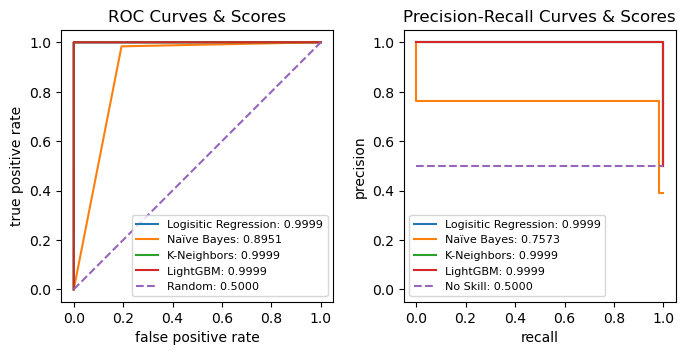

In [24]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, PrecisionRecallDisplay

def plot_curves(test_set, predictions):
    '''
    Plots ROC curves and precision-recall curves for each classifier and their corresponding scores.
    '''
    # initialize lists to store scores
    roc_data = []
    prc_data = []
    auc_scores = []
    ap_scores = []

    # Loop through classifiers and their predictions
    for name, pred in predictions.items():
        # calculate ROC curve
        fpr, tpr, _ = roc_curve(pred, test_set)
        roc_data.append((fpr, tpr))

        # calculate ROC-AUC score
        roc_auc = roc_auc_score(pred, test_set)
        auc_scores.append(roc_auc)

        # calculate precision-recall curve
        prec, rec, _ = precision_recall_curve(pred, test_set)
        prc_data.append((prec, rec))

        # calculate average precision score
        ap = average_precision_score(pred, test_set)
        ap_scores.append(ap)
    
    # plot the ROC and precision-recall curves
    fig, axes = plt.subplots(1, 2, figsize=(7, 3.5))

    # 1. plot ROC curves
    for (fpr, tpr), auc, name in zip(roc_data, auc_scores, predictions.keys()):
        RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=f'{name}: {auc:.4f}').plot(ax=axes[0])

    axes[0].plot([0, 1], [0, 1], linestyle='--', label='Random: 0.5000')
    axes[0].set_title('ROC Curves & Scores')
    axes[0].set_xlim([-0.05, 1.05])
    axes[0].set_ylim([-0.05, 1.05])
    axes[0].set_xlabel('false positive rate')
    axes[0].set_ylabel('true positive rate')
    axes[0].legend(loc='lower right', fontsize=8)

    # 2. plot precision-recall curves
    for (prec, rec), ap, name in zip(prc_data, ap_scores, predictions.keys()):
        PrecisionRecallDisplay(prec, rec, estimator_name=f'{name}: {ap:.4f}').plot(ax=axes[1])

    no_skill = len(test_set[test_set == 1]) / len(test_set)  # no-skill, random, or baseline
    axes[1].plot([0, 1], [no_skill, no_skill], linestyle='--', label=f'No Skill: {no_skill:.4f}')
    axes[1].set_title('Precision-Recall Curves & Scores')
    axes[1].set_xlim([-0.05, 1.05])
    axes[1].set_ylim([-0.05, 1.05])
    axes[1].set_xlabel('recall')
    axes[1].set_ylabel('precision')
    axes[1].legend(loc='lower left', fontsize=8)

    plt.tight_layout()
    plt.show()

# k-means evaluation curves
plot_curves(y_train_kmeans, pred_kmeans)

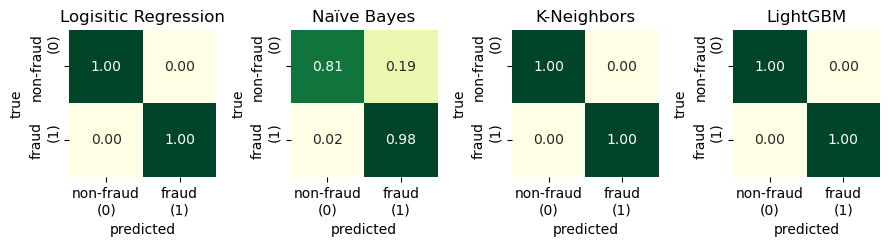

In [25]:
# k-means confusion matrices
plot_confusion_matrices(test_set=y_train_kmeans, predictions=pred_kmeans)

> Based on these charts we can easily notice how benificial is resampling an imbalanced dataset. Almost all models have 99% accuracy except the Naïve Bayes. It is the least balanced of all models but still has a large improvement compared to the previous results.

### 5. ADASYN Oversampling

Adaptive Synthetic (ADASYN) algorithm is another SMOTE technique that generates different number of samples depending on an estimate of the local distribution of the class to be oversampled. Since the fraudulent transactions are less frequent we will adopt this sampling strategy for the minority class to equalize the target distribution.

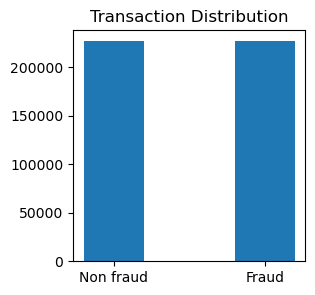

+-----------+--------+---------+
| Class     | Count  | Percent |
+-----------+--------+---------+
| Non-fraud | 226602 | 50.003  |
| Fraud     | 226575 | 49.997  |
+-----------+--------+---------+


In [26]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN(sampling_strategy='minority', random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

# plot target distribution
count_target(frame=pd.concat([X_adasyn, y_adasyn], axis=1))

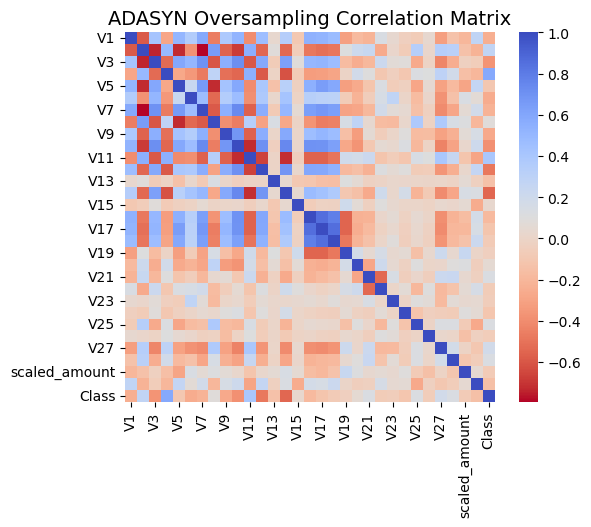

In [27]:
# visualize correlations within dataset
heatmap(pd.concat([X_adasyn, y_adasyn], axis=1).corr(), cmap='coolwarm_r', square=True)
plt.title('ADASYN Oversampling Correlation Matrix', fontsize=14)
plt.show()

In [28]:
# dictionary to store F1 scores
adasyn_scores = {}

# initialize score table
table = PrettyTable(['Classifier', 'F1-Score'], align='l', header_style=None)

for key, classifier in classifiers.items():
    classifier.fit(X_adasyn, y_adasyn)
    training_score = cross_val_score(classifier, X_adasyn, y_adasyn, cv=5, scoring='f1')
    adasyn_scores[key] = training_score.mean()
    table.add_row([classifier.__class__.__name__, round(training_score.mean() * 100, 4)])

table.reversesort = True
print(table.get_string(sortby='F1-Score'))

+----------------------+----------+
| Classifier           | F1-Score |
+----------------------+----------+
| KNeighborsClassifier | 95.2249  |
| LGBMClassifier       | 93.6992  |
| LogisticRegression   | 84.9691  |
| GaussianNB           | 60.9264  |
+----------------------+----------+


In [29]:
# ADASYN predictions
pred_adasyn = perform_predictions(X_adasyn, y_adasyn)

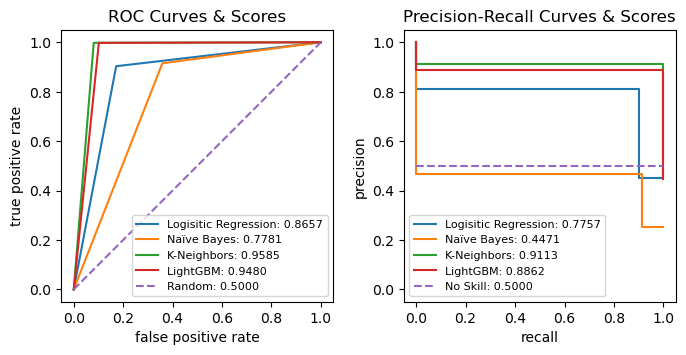

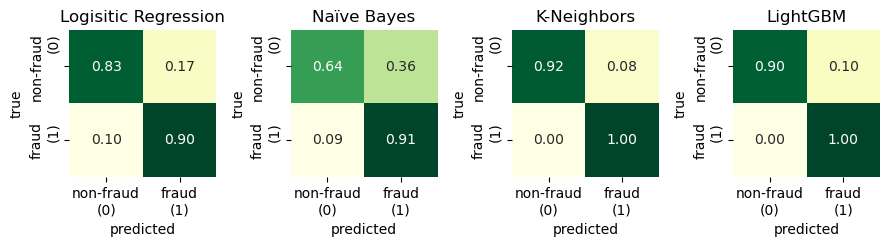

In [30]:
# ADASYN evaluation curves
plot_curves(y_adasyn, pred_adasyn)

# ADASYN confusion matrices
plot_confusion_matrices(y_adasyn, pred_adasyn)

> The k-nearest neighbors performanced the best. We can notice that all models still tend to predict non-fraudulent transactions more accurately.

### 6. SMOTE & ENN

A combination of oversampling and undersampling using SMOTE and ENN (edited nearest neighbors). This method oversamples rows using SMOTE and cleans using ENN. Again, we will apply this strategy to the minority class.

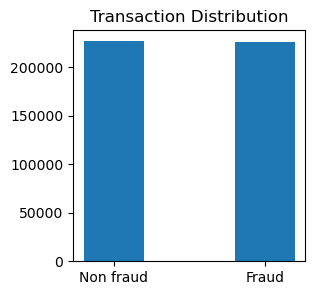

+-----------+--------+---------+
| Class     | Count  | Percent |
+-----------+--------+---------+
| Non-fraud | 226602 | 50.0438 |
| Fraud     | 226205 | 49.9562 |
+-----------+--------+---------+


In [31]:
from imblearn.combine import SMOTEENN

smote_enn = SMOTEENN(sampling_strategy='minority', random_state=42)
X_smote_enn, y_smote_enn = smote_enn.fit_resample(X_train, y_train)

# plot target distribution
count_target(frame=pd.concat([X_smote_enn, y_smote_enn], axis=1))

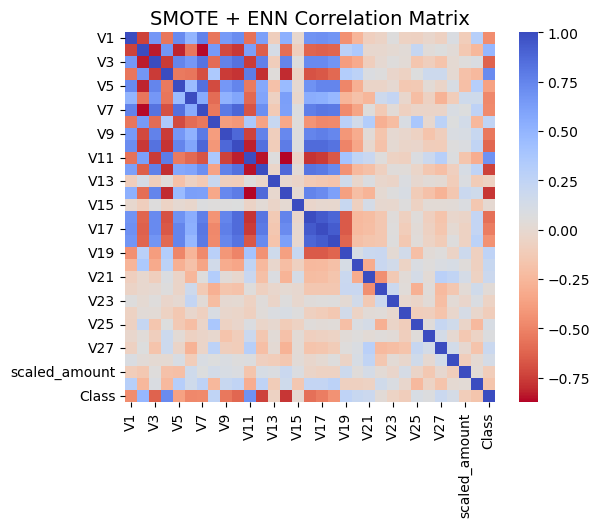

In [32]:
# visualize correlations within dataset
heatmap(pd.concat([X_smote_enn, y_smote_enn], axis=1).corr(), cmap='coolwarm_r', square=True)
plt.title('SMOTE + ENN Correlation Matrix', fontsize=14)
plt.show()

In [33]:
# dictionary to store F1 scores
smote_enn_scores = {}

# initialize score table
table = PrettyTable(['Classifier', 'F1-Score'], align='l', header_style=None)

for key, classifier in classifiers.items():
    classifier.fit(X_smote_enn, y_smote_enn)
    training_score = cross_val_score(classifier, X_smote_enn, y_smote_enn, cv=5, scoring='f1')
    smote_enn_scores[key] = training_score.mean()
    table.add_row([classifier.__class__.__name__, round(training_score.mean() * 100, 4)])

table.reversesort = True
print(table.get_string(sortby='F1-Score'))

+----------------------+----------+
| Classifier           | F1-Score |
+----------------------+----------+
| KNeighborsClassifier | 99.9663  |
| LGBMClassifier       | 99.9396  |
| LogisticRegression   | 94.4855  |
| GaussianNB           | 89.9324  |
+----------------------+----------+


In [34]:
# SMOTE + ENN predictions
pred_smote_enn = perform_predictions(X_smote_enn, y_smote_enn)

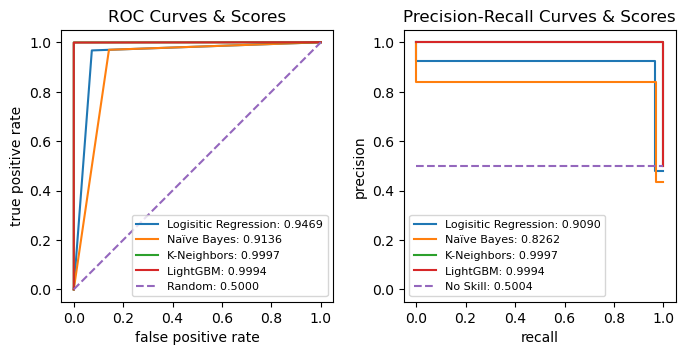

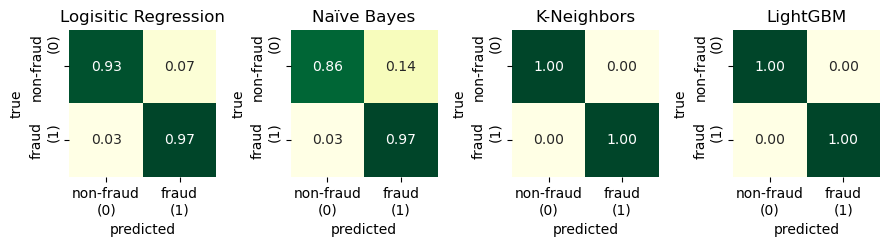

In [35]:
# SMOTE + ENN evaluation curves
plot_curves(y_smote_enn, pred_smote_enn)

# SMOTE + ENN confusion matrices
plot_confusion_matrices(y_smote_enn, pred_smote_enn)

> This technique yield relatively balanced classifications with F1 scores near 0.9. The overall performances are high.

### 7. Random Undersampling

Random undersampling involves randomly selecting examples from the majority class to delete from the training dataset. This has the effect of reducing the number of examples in the majority class in the transformed version of the training dataset. This process can be repeated until the desired class distribution is achieved, such as an equal number of examples for each class.

This approach may be more suitable for datasets with class imbalance, provided there are a sufficient number of examples in the minority class, allowing for the development of a useful model. In other words, this means that the undersampling carries the risk of losing important information for the learning process.

The sampling strategy will be applied to the majority class, as it is the class to be reduced.

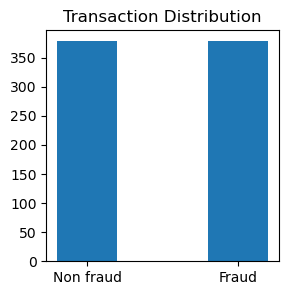

+-----------+-------+---------+
| Class     | Count | Percent |
+-----------+-------+---------+
| Non-fraud | 378   | 50.0    |
| Fraud     | 378   | 50.0    |
+-----------+-------+---------+


In [36]:
from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_under, y_under = undersample.fit_resample(X_train, y_train)

# plot target distribution
count_target(frame=pd.concat([X_under, y_under], axis=1))

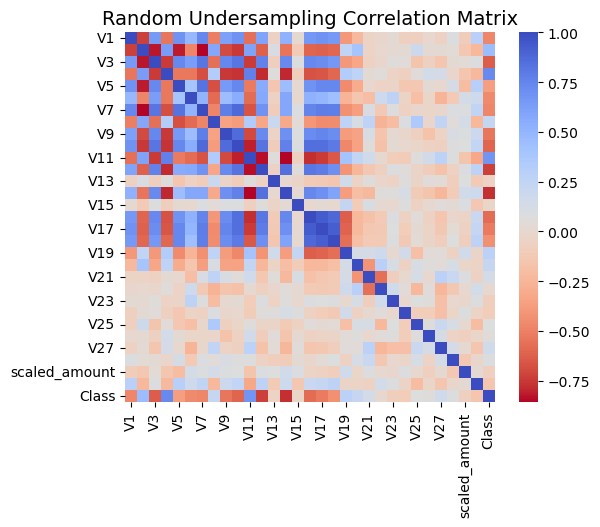

In [37]:
# visualize correlations within dataset
heatmap(pd.concat([X_under, y_under], axis=1).corr(), cmap='coolwarm_r', square=True)
plt.title('Random Undersampling Correlation Matrix', fontsize=14)
plt.show()

In [38]:
# dictionary to store F1 scores
under_scores = {}

# initialize score table
table = PrettyTable(['Classifier', 'F1-Score'], align='l', header_style=None)

for key, classifier in classifiers.items():
    classifier.fit(X_under, y_under)
    training_score = cross_val_score(classifier, X_under, y_under, cv=5, scoring='f1')
    under_scores[key] = training_score.mean()
    table.add_row([classifier.__class__.__name__, round(training_score.mean() * 100, 4)])

table.reversesort = True
print(table.get_string(sortby='F1-Score'))

+----------------------+----------+
| Classifier           | F1-Score |
+----------------------+----------+
| LogisticRegression   | 93.9427  |
| LGBMClassifier       | 93.7498  |
| KNeighborsClassifier | 92.9543  |
| GaussianNB           | 90.108   |
+----------------------+----------+


In [39]:
# random undersampling predictions
pred_under = perform_predictions(X_under, y_under)

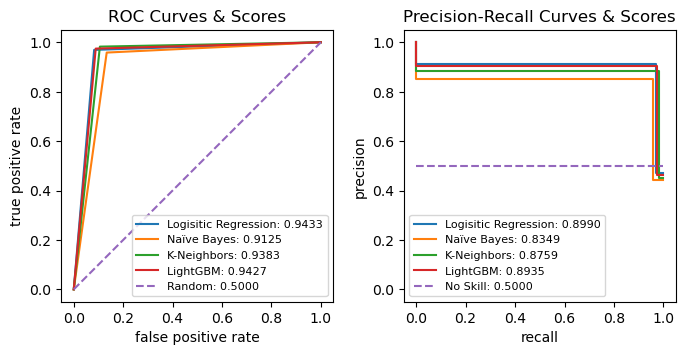

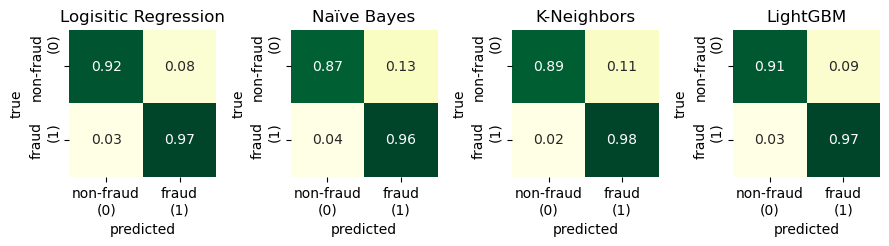

In [40]:
# random undersampling evaluation curves
plot_curves(y_under, pred_under)

# random undersampling confusion matrices
plot_confusion_matrices(y_under, pred_under)

> Overall very good performances. The curves indicate very balanced performances. Based on recieved scores the logistic regression is the most effective with random undersampling.

### 8. Near Miss Undersampling

Near Miss is an undersampling algorithm that selects samples from the majority class that are closest to the minority class based on their distance, effectively reducing the overlap between the two classes. This technique removes datapoints from the majority class thereby trying to balance the distribution.

One hyperparameter that is easy to tune is the k-neighbors. We will evaluate performance using F1 scores to find the optimal number of neighbors. The base estimator will be the Naïve Bayes due to its fast runtime.

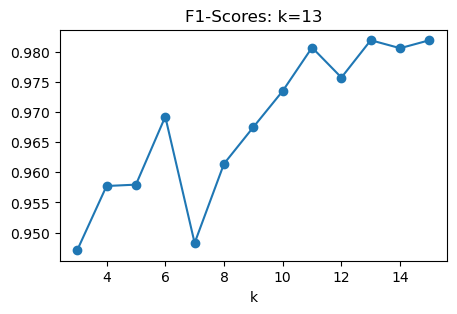

In [41]:
from imblearn.under_sampling import NearMiss
from statistics import mean

# list for F1 scores
f1_scores = []

# loop through each k-neighbor
for k in range(3, 16):
    near_miss = NearMiss(sampling_strategy='majority', n_neighbors=k)
    X_near_miss, y_near_miss = near_miss.fit_resample(X_train, y_train)

    training_score = cross_val_score(GaussianNB(), X_near_miss, y_near_miss, cv=5, scoring='f1')
    f1_scores.append(mean(training_score))

plt.figure(figsize=(5, 3))
plt.plot(range(3, 16), f1_scores, marker='o')
plt.title(f'F1-Scores: k={f1_scores.index(max(f1_scores)) + 3}')
plt.xlabel('k')
plt.show()

> Thirteen neighbors is the best choice for the Near Miss sampling technique.

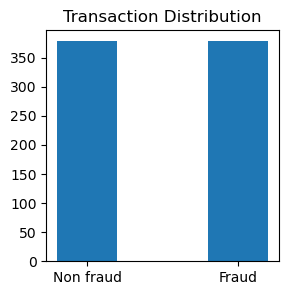

+-----------+-------+---------+
| Class     | Count | Percent |
+-----------+-------+---------+
| Non-fraud | 378   | 50.0    |
| Fraud     | 378   | 50.0    |
+-----------+-------+---------+


In [42]:
# run Near Miss
num_neighbors = 13
near_miss = NearMiss(sampling_strategy='majority', n_neighbors=num_neighbors)
X_near_miss, y_near_miss = near_miss.fit_resample(X_train, y_train)

# plot target distribution
count_target(frame=pd.concat([X_near_miss, y_near_miss], axis=1))

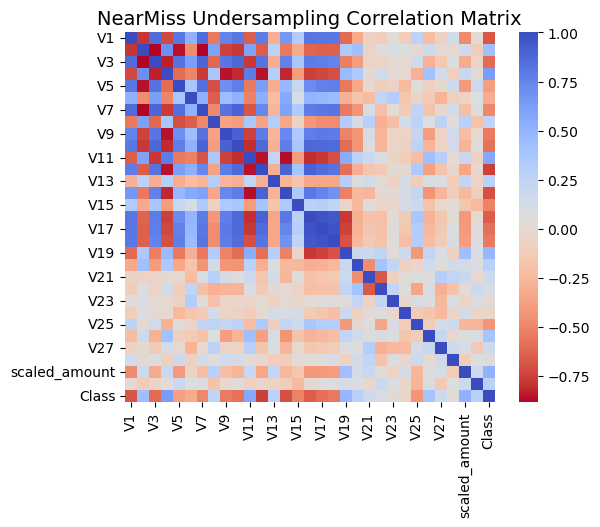

In [43]:
# visualize correlations within dataset
heatmap(pd.concat([X_near_miss, y_near_miss], axis=1).corr(), cmap='coolwarm_r', square=True)
plt.title('NearMiss Undersampling Correlation Matrix', fontsize=14)
plt.show()

In [44]:
# dictionary to store F1 scores
near_miss_scores = {}

# initialize score table
table = PrettyTable(['Classifier', 'F1-Score'], align='l', header_style=None)

for key, classifier in classifiers.items():
    classifier.fit(X_near_miss, y_near_miss)
    training_score = cross_val_score(classifier, X_near_miss, y_near_miss, cv=5, scoring='f1')
    near_miss_scores[key] = training_score.mean()
    table.add_row([classifier.__class__.__name__, round(training_score.mean() * 100, 4)])

table.reversesort = True
print(table.get_string(sortby='F1-Score'))

+----------------------+----------+
| Classifier           | F1-Score |
+----------------------+----------+
| GaussianNB           | 98.1947  |
| LGBMClassifier       | 97.3644  |
| LogisticRegression   | 97.0284  |
| KNeighborsClassifier | 95.1212  |
+----------------------+----------+


In [45]:
# Near Miss undersampling predictions
pred_near_miss = perform_predictions(X_near_miss, y_near_miss)

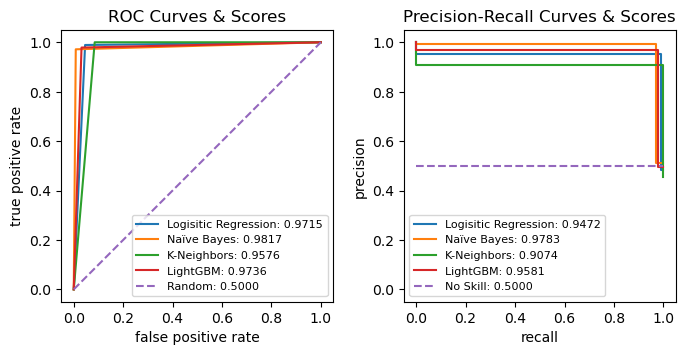

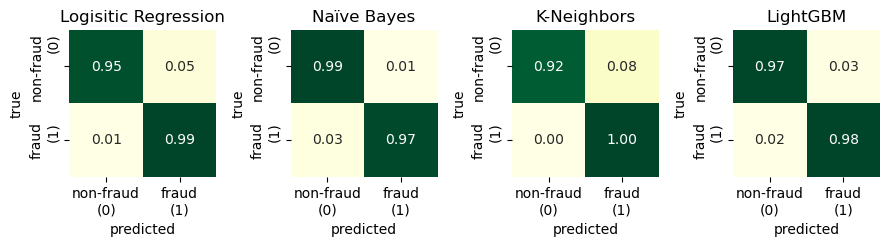

In [46]:
# random undersampling evaluation curves
plot_curves(y_near_miss, pred_near_miss)

# random undersampling confusion matrices
plot_confusion_matrices(y_near_miss, pred_near_miss)

> Near Miss resampling proved to be effective for this dataset. The trained models have very high performances. It stands out with near-perfect scores for logistic regression and Naïve Bayes, but slightly lower performance for k-nearest neighbors and light gradient-boosting machine, indicating strong but not perfect balance.

### 9. Random Oversampling

This basic method oversamples the minority class by randomly selecting samples with replacement. No additional operations are performed.

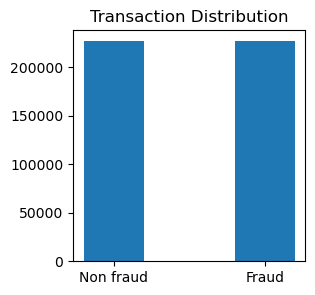

+-----------+--------+---------+
| Class     | Count  | Percent |
+-----------+--------+---------+
| Non-fraud | 226602 | 50.0    |
| Fraud     | 226602 | 50.0    |
+-----------+--------+---------+


In [47]:
from imblearn.over_sampling import RandomOverSampler

undersample = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_over, y_over = undersample.fit_resample(X_train, y_train)

# plot target distribution
count_target(frame=pd.concat([X_over, y_over], axis=1))

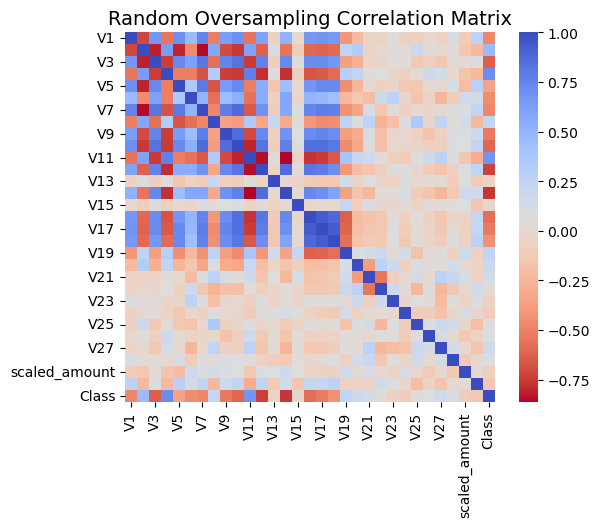

In [48]:
# visualize correlations within dataset
heatmap(pd.concat([X_over, y_over], axis=1).corr(), cmap='coolwarm_r', square=True)
plt.title('Random Oversampling Correlation Matrix', fontsize=14)
plt.show()

In [49]:
# dictionary to store F1 scores
over_scores = {}

# initialize score table
table = PrettyTable(['Classifier', 'F1-Score'], align='l', header_style=None)

for key, classifier in classifiers.items():
    classifier.fit(X_over, y_over)
    training_score = cross_val_score(classifier, X_over, y_over, cv=5, scoring='f1')
    over_scores[key] = training_score.mean()
    table.add_row([classifier.__class__.__name__, round(training_score.mean() * 100, 4)])

table.reversesort = True
print(table.get_string(sortby='F1-Score'))

+----------------------+----------+
| Classifier           | F1-Score |
+----------------------+----------+
| LGBMClassifier       | 99.9846  |
| KNeighborsClassifier | 99.9594  |
| LogisticRegression   | 94.4653  |
| GaussianNB           | 90.2741  |
+----------------------+----------+


In [50]:
# random oversampling predictions
pred_over = perform_predictions(X_over, y_over)

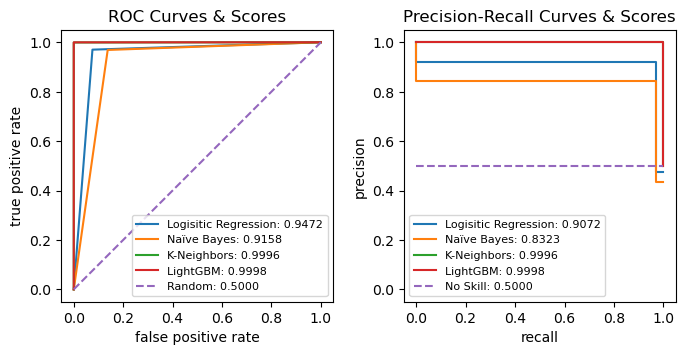

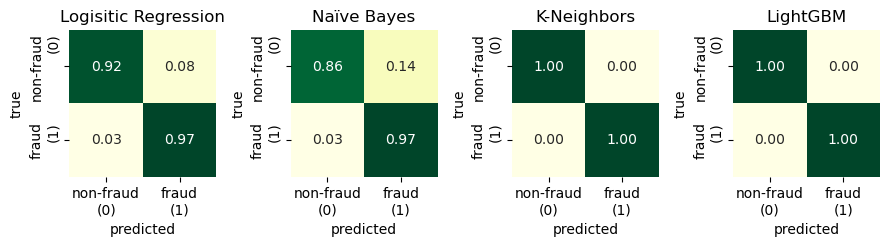

In [51]:
# random oversampling evaluation curves
plot_curves(y_over, pred_over)

# random oversampling confusion matrices
plot_confusion_matrices(y_over, pred_over)

> Overall very good performances. Light gradient-boosting machine and k-nearest neighbors models are the top choices.

### 10. Balance Bagging Classifying

The balance bagging classifier is a specialized ensemble learning algorithm that is designed specifically to address the problem of imbalanced classification. It includes an additional step to balance the training set during model fitting based on provided strategy. It also introduces a base estimator and sampling strategy to fit the subsets. Since the fraudulent transactions are in the minority class, this is the class we need to resample.

This technique does not generate new datasets but instead directly returns predictions.

In [52]:
from imblearn.ensemble import BalancedBaggingClassifier

# dictionary to store F1 scores
bbc_scores = {}

# initialize table
table = PrettyTable(['Classifier', 'F1-Score'], align='l', header_style=None)

for key, classifier in classifiers.items():
    bbc = BalancedBaggingClassifier(classifier, sampling_strategy='not majority', replacement=False, random_state=42)
    bbc.fit(X_train, y_train)
    training_score = cross_val_score(bbc, X_train, y_train, cv=5, scoring='f1')
    bbc_scores[key] = training_score.mean()
    table.add_row([classifier.__class__.__name__, round(training_score.mean() * 100, 4)])

table.reversesort = True
print(table.get_string(sortby='F1-Score'))

+----------------------+----------+
| Classifier           | F1-Score |
+----------------------+----------+
| KNeighborsClassifier | 81.4494  |
| LogisticRegression   | 73.193   |
| LGBMClassifier       | 56.8226  |
| GaussianNB           | 10.7587  |
+----------------------+----------+


In [53]:
def bbc_predictions(X_train, y_train, method='predict'):
    '''
    Returns predictions for each classifier - only for balanced bagging.
    Method: `predict` - returns classes, `predict_proba` - returns probabilities.
    '''
    # define properties
    props_kwargs = {
        'X': X_train,
        'y': y_train,
        'cv': 5,
        'verbose': 0,
        'method': method,
    }

    bbc_props = {
        'sampling_strategy': 'not majority',
        'replacement': False,
        'random_state': 42,
    }

    # store probabilities for each model
    predictions_dict = {}

    for key, classifier in classifiers.items():
        predictions_dict[key] = cross_val_predict(BalancedBaggingClassifier(classifier, **bbc_props), **props_kwargs)

    return predictions_dict

# balanced bagging predictions
pred_bbc = bbc_predictions(X_train, y_train)

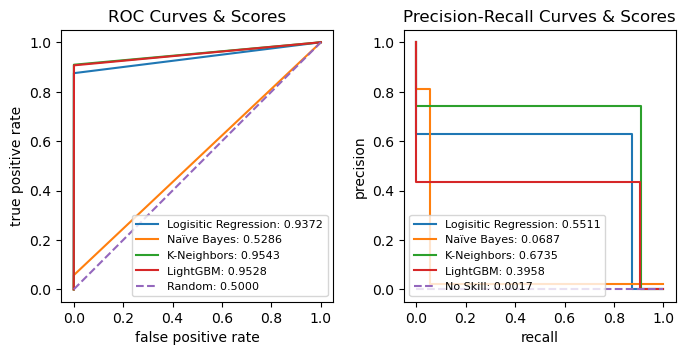

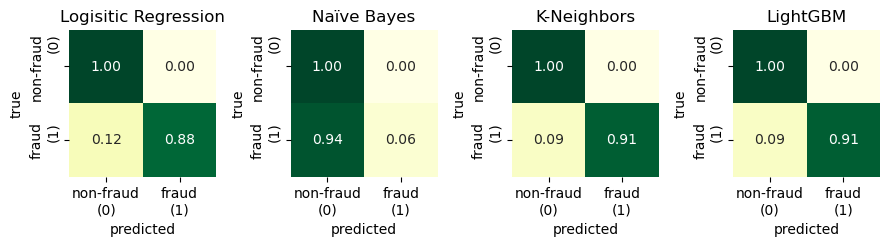

In [54]:
# balanced bagging evaluation curves
plot_curves(y_train, pred_bbc)

# balanced bagging confusion matrices
plot_confusion_matrices(y_train, pred_bbc)

> The Naïve Bayes clearly does not recognize fraud samples and performs random guesses. The remaining classifiers performed very similary and slightly misclassified a minor subset of fraudulence transactions.

Finally, after running all resampling methodologies, we will organize and display the evaluation metrics - F1 scores - in tabular form to compare the results.

In [55]:
# initialize F1 score dictionaries and assign keys based on their resampling techniques
f1_scores1 = {
    'No Sampling': reg_scores,
    'K-Means': kmeans_scores,
    'ADASYN': adasyn_scores,
    'SMOTE-ENN': smote_enn_scores,
}

f1_scores2 = {
    'Random Undersampling': under_scores,
    'Near Miss': near_miss_scores,
    'Random Oversampling': over_scores,
    'Balanced Bagging': bbc_scores,
}

pd.DataFrame.from_dict({**f1_scores1, **f1_scores2}, orient='index').round(4)

,Logisitic Regression,Naïve Bayes,K-Neighbors,LightGBM
No Sampling,0.7344,0.1068,0.8152,0.2998
K-Means,0.9999,0.7744,0.9999,0.9999
ADASYN,0.8497,0.6093,0.9522,0.9370
SMOTE-ENN,0.9449,0.8993,0.9997,0.9994
Random Undersampling,0.9394,0.9011,0.9295,0.9375
Near Miss,0.9703,0.9819,0.9512,0.9736
Random Oversampling,0.9447,0.9027,0.9996,0.9998
Balanced Bagging,0.7319,0.1076,0.8145,0.5682


> Oversampling techniques tend to influence the classifiers to optimize its performances. Unlike undersampling, oversampling introduces more information (instances) into the dataset thus increasing classifying fraudulent transactions.
>
> While k-means achieves very high F1 scores (close to 1.0) across all models, this may indicate that the technique is overly biased towards achieving very high scores, which might not reflect real-world performance. The dramatic difference between the scores of Naïve Bayes (0.7744) and the others (close to 1.0) suggests that k-means may have produced imbalanced results for certain classifiers.
>
> SMOTE-ENN (a combination of SMOTE and edited nearest neighbors) appears to have the most balanced F1 scores across the classifiers. The scores are all high and relatively similar, with no significant drop-offs for any particular model. Random undersampling also performs well and shows a good balance across models, though slightly less consistent than SMOTE-ENN.
>
> Balanced bagging performed poorly returning similar metric values as without any sampling. This makes it the least balanced method in this comparison.

### 11. Conclusions

The purpose of this project was to perform a binary classification task on a credit card dataset to identify fraud and non-fraud transactions. The EDA revealed that the dataset was heavily imbalanced with fraudulent transactions accounting for 0.17% of all instances. The notebook demonstrated a few commonly used methodologies for overcoming this issue in data science. We showed that balancing the data is crucial to avoid skewed predictions and to reveal stronger correlations between feature. Resampling also enhances the robustness of the classifiers' performance.

Although accuracy is one of the most commonly used evaluation metric for classification tasks - due to its simplicity - we proved that depending only on it can provide misleading insights when applied to imbalanced datasets. Classifiers tend to favor the majority class, neglecting the minority class due to its lower representation. In other words, the majority class dominates the minority class. Instead, it is optimal to implement other relevant metrics, such as: precision, recall, confusion matrix, AUC, ROC-AUC, MCC, etc. Accuracy is a suitable metric to use **after** balancing the dataset. For this project, we used the F1 score as the primary evaluation metric.

When reviewing the evaluation results, we should favor the resampling technique that provides balanced results across all four models, rather than focusing solely on the overall highest score in the table. While k-means achieved the highest scores, the Naïve Bayes score indicates underperformance, which may suggest an imbalance. Thus, the optimal resampling based on the F1 scores is **SMOTE-ENN** with k-nearest neighbors.

**References:**
* Md. Alam Hossain, Mst. Shimu Khatun, R. Alam Bhuiyan, Md. Taslim, 2022, *Handling Class Imbalance in Credit Card Fraud Using Various Sampling Techniques*, [Full Text](https://www.researchgate.net/publication/364121589_Handling_Class_Imbalance_in_Credit_Card_Fraud_Using_Various_Sampling_Techniques)
* M. Isangediok, K. Gajamannage, 2022, *Fraud Detection Using Optimized Machine Learning Tools Under Imbalance Classes*, [Full Text](https://www.researchgate.net/publication/363333126_Fraud_Detection_Using_Optimized_Machine_Learning_Tools_Under_Imbalance_Classes)
* A. C. Müller, S. Guido, 2016, *Introduction to Machine Learning with Python. A Guide for Data Scientists*

**Bonus: Display Accuracies**

In [56]:
from sklearn.metrics import accuracy_score

# dictionary of predictions
predictions_dict = {
    'No Sampling': pred_reg,
    'K-Means': pred_kmeans,
    'ADASYN': pred_adasyn,
    'SMOTE-ENN': pred_smote_enn,
    'Random Undersampling': pred_under,
    'Near Miss': pred_near_miss,
    'Random Oversampling': pred_over,
    'Balanced Bagging': pred_bbc,
}

# list of true values
y_true_list = [
    y_train,
    y_train_kmeans,
    y_adasyn,
    y_smote_enn,
    y_under,
    y_near_miss,
    y_over,
    y_train,
]

# store accuracies for each model & resampling technique
accuracy_scores = {}

for (method, mod_pred), y_true in zip(predictions_dict.items(), y_true_list):
    model_accuracies = {}
    for model_name, y_pred in mod_pred.items():
        accuracy = accuracy_score(y_true, y_pred)
        model_accuracies[model_name] = accuracy
    
    # store the model accuracies for the current technique in the main dictionary
    accuracy_scores[method] = model_accuracies

pd.DataFrame.from_dict(accuracy_scores, orient='index').round(4)

,Logisitic Regression,Naïve Bayes,K-Neighbors,LightGBM
No Sampling,0.9992,0.9774,0.9994,0.9949
K-Means,0.9999,0.8753,0.9999,0.9999
ADASYN,0.8619,0.7109,0.9551,0.9425
SMOTE-ENN,0.9460,0.9060,0.9997,0.9994
Random Undersampling,0.9418,0.9074,0.9339,0.9405
Near Miss,0.9709,0.9815,0.9537,0.9735
Random Oversampling,0.9461,0.9090,0.9996,0.9998
Balanced Bagging,0.9992,0.9776,0.9994,0.9990
